In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.spatial.distance import pdist, squareform, correlation
from fastcluster import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import squareform
from sklearn.datasets import load_breast_cancer

import warnings
warnings.filterwarnings('ignore')

# Hierarchical clustering of features

Many datasets contain redundant information that potentially slows down the analysis and training of models. There are several methods to reduce the dimensionality of a dataset, from mapping methods such as PCA, t-SNE and UMAP, to feature selection methods. 
Performing hierarchical clustering on the features of a dataset is a possible method to perform feature selection ([Reference](https://dl.acm.org/doi/abs/10.1145/2063576.2063716)), as well as a great visualization tool to get a rough idea of how much redundancy is contained in a dataset, which makes it an ideal candidate for Exploratory Data Analysis.

In this notebook I will use as example the UCI ML Breast Cancer Wisconsin (Diagnostic) dataset, and I will show how to perform hierarchical clustering on the correlation matrix of the feature space. 
Since there is no assurance that the features of the dataset are ordered in the ideal manner to perform hierarchical clustering, I will rely on the concept of [seriation](http://www.atgc-montpellier.fr/permutmatrix/manual/SeriationCorps.htm) to reorder the features as to highlight the underlying patterns present in the data.
The method used relies on finding the ideal order for a distance matrix, so I will convert the correlation coefficient between features $i$ and $j$, $\rho_{ij}$, to a distance $d_{ij} = 1 - |\rho_{ij}|$, because I consider both positive and negative values of the Pearson Correlation Coefficient to indicate a dependency between the variables.


__Credits and links__

The code used to sort a distance matrix is taken from
https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html

## Preliminary setup and data loading

In [2]:
# Load the dataset
dataset = load_breast_cancer()
ftrs = dataset.data

# Display the features
pd.DataFrame(ftrs)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
# Setup the necessary functions for reordering a distance matrix.
# These two functions are taken from https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html

def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method, preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage


## Calculate and display the correlation matrix

In [4]:
# Calculate the 30x30 correlation matrix for the dataset
pearson_corr_matrix = np.corrcoef(ftrs, rowvar=False)

# Additional corrections for numerical errors to ensure symmetry of the matrix and
# that the diagonal is filled with 1s.
pearson_corr_matrix = (pearson_corr_matrix + pearson_corr_matrix.T)/2                         # made symmetric
np.fill_diagonal(pearson_corr_matrix, 1)  

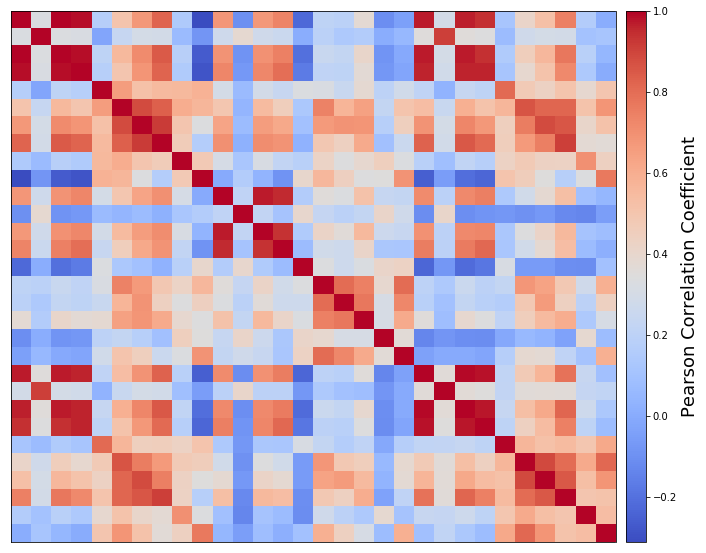

In [5]:
# from https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html

# Plotting the correlation matrix as heatmap
fig = plt.figure(figsize=(14,9))

# Matrix
axmatrix = fig.add_axes([0.05,0.1,0.6,0.82])
im = axmatrix.matshow(pearson_corr_matrix, aspect='auto', origin='upper', cmap=plt.cm.coolwarm)#YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Colorbar
axcolor = fig.add_axes([0.66,0.1,0.02,0.82])
cb = plt.colorbar(im, cax=axcolor)
cb.set_label(label='Pearson Correlation Coefficient', size=18)

plt.tight_layout()
fig.show()

As the previous plot shows, it is difficult to infer any pattern from this correlation matrix. Some portions, as the two red blocks close to the upper-right and bottom-left corners, suggest that there might be a better ordering that could evidence the "blocks" of correlated features (__Blockmodeling__).

## Reordering and clustering the correlation matrix

Here I will employ the two previously shown reordering functions, to let the underlying patterns emerge.

It is important to note that __there is no single best ordering__, but different choices will produce different block patterns.

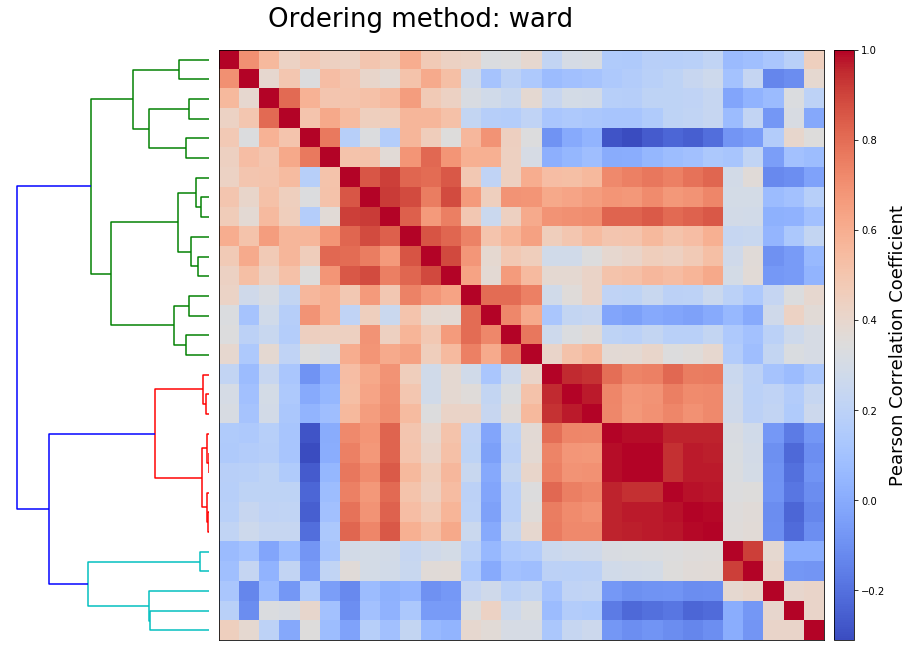

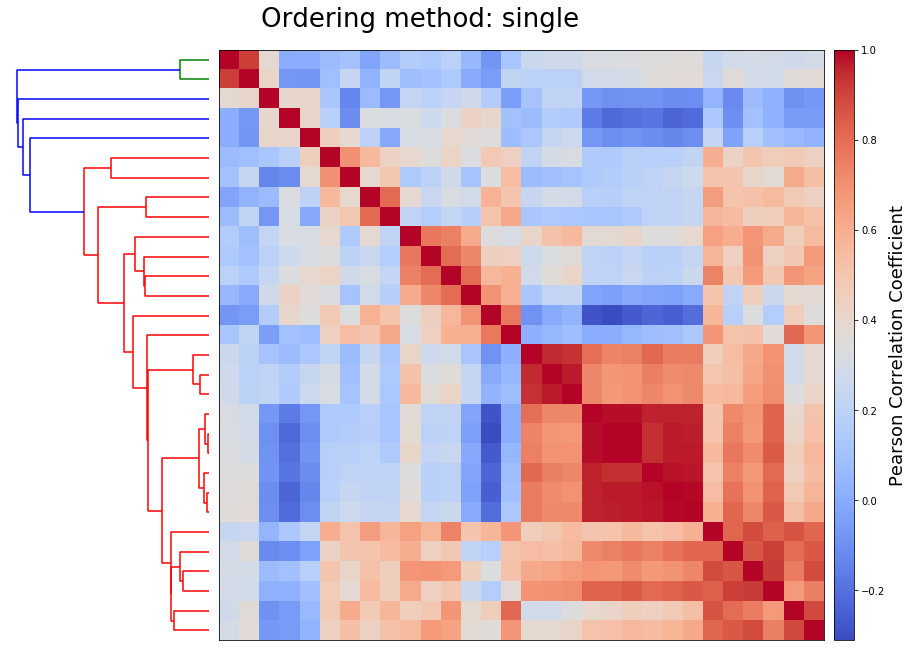

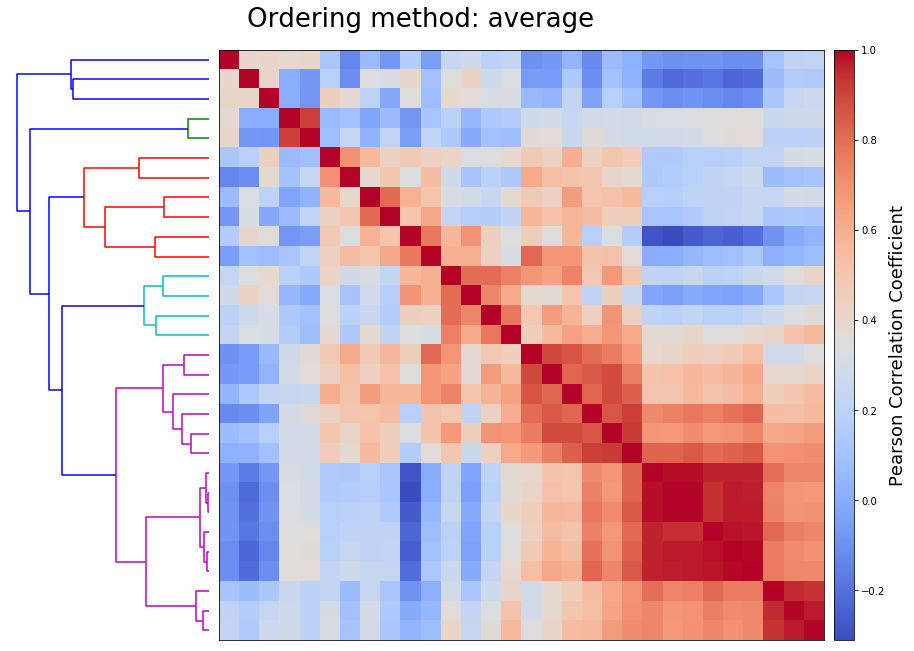

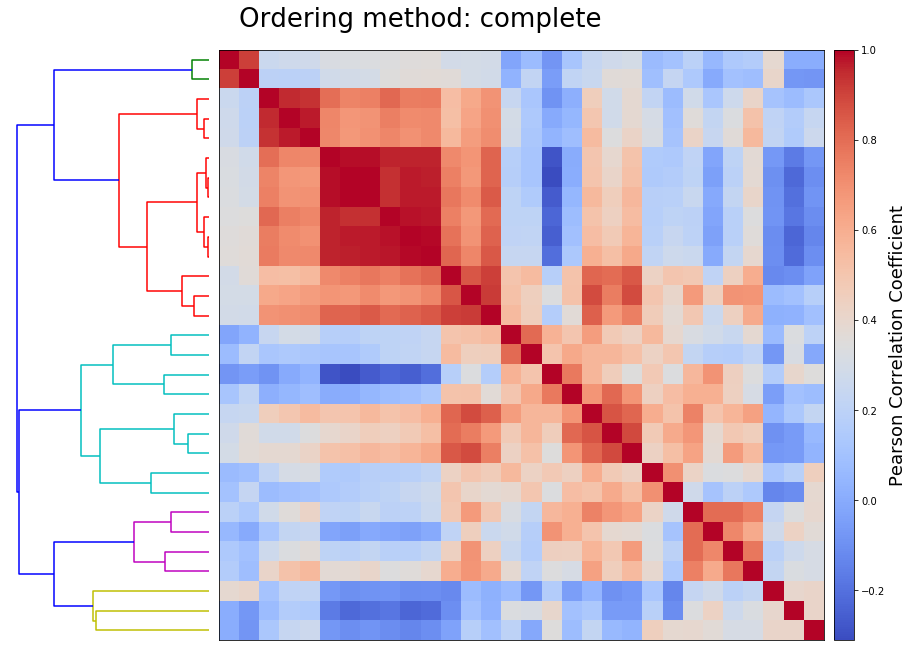

In [6]:
# Convert the correlation matrix to a distance matrix
dissimilarity_matrix = 1 - np.abs(pearson_corr_matrix)

# There are four available methods to determine the ordering of the features
ordering_methods = ["ward", "single", "average", "complete"]

for method in ordering_methods:
    # Compute the ordering of the features and the hierarchical clustering
    ordered_dist_mat, res_order, hierarchy = compute_serial_matrix(dissimilarity_matrix, method=method)
    
    # Compute the correlation matrix for the ordered features
    ord_pearson_corr_matrix = np.corrcoef(dataset.data[:,res_order], rowvar=False) 
    
    # Plot the correlation matrix with the dendrogram
    fig = plt.figure(figsize=(14,10))
    
    # Dendrogram
    #ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
    axtree = fig.add_axes([0.09,0.1,0.2,0.82], frameon=False)
    Z1 = dendrogram(hierarchy, orientation='left')
    axtree.invert_yaxis()
    axtree.set_xticks([])
    axtree.set_yticks([])
    
    # Matrix
    #axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.82])
    im = axmatrix.matshow(ord_pearson_corr_matrix, aspect='auto', origin='upper', cmap=plt.cm.coolwarm)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])
    
    # Colorbar
    #axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
    axcolor = fig.add_axes([0.91,0.1,0.02,0.82])
    cb = plt.colorbar(im, cax=axcolor)
    cb.set_label(label='Pearson Correlation Coefficient', size=18)
    
    
    fig.suptitle('Ordering method: {}'.format(method), fontsize=26)
    plt.tight_layout()
    fig.show()

As evindenced by these plots, there are clear block structures emerging from the data, which makes it possible to cluster together highly correlated features. One way to achieve that is to simply cut the dendrogram at a certain height and consider the branches as the clusters.

As previously mentioned, there is not a clear best ordering, but rather different methods produce different block structures.